In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised
# from attention import Attention

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
dataset = pd.read_csv('../../data//pollution.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,pollution,dew,temp,press,wnd_spd,snow,rain,NE,NW,SE,cv
date,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,231.97,0,0,0,1,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,237.78,0,0,0,1,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,242.70,0,0,0,1,0,0


In [4]:
print(dataset.columns)

Index(['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE',
       'NW', 'SE', 'cv'],
      dtype='object')


In [5]:
# specify the number of lag hours
n_hours = 24*3
K = 12

### Target time series (4)
- 'WS_S1',  'TWS_S25A', 'TWS_S25B', 'TWS_S26',    
        
               
### Prior known covariates (9)
- 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B',  'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN'


### Prior unknown covariates (6)
- 'FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26'

#### Target time series: water stage (4)

In [6]:
# Pre-processing
stages = dataset[['pollution']]
print("stages.shape:", stages.shape)


stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (43800, 1)
stages_supervised.shape: (43717, 84)


In [7]:
stages_supervised

,var1(t-72),var1(t-71),var1(t-70),var1(t-69),var1(t-68),var1(t-67),var1(t-66),var1(t-65),var1(t-64),var1(t-63),...,var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6),var1(t+7),var1(t+8),var1(t+9),var1(t+10),var1(t+11)
date,,,,,,,,,,,,,,,,,,,,,
2010-01-05 00:00:00,129.0,148.0,159.0,181.0,138.0,109.0,105.0,124.0,120.0,132.0,...,27.0,25.0,28.0,28.0,27.0,27.0,27.0,29.0,36.0,30.0
2010-01-05 01:00:00,148.0,159.0,181.0,138.0,109.0,105.0,124.0,120.0,132.0,140.0,...,25.0,28.0,28.0,27.0,27.0,27.0,29.0,36.0,30.0,27.0
2010-01-05 02:00:00,159.0,181.0,138.0,109.0,105.0,124.0,120.0,132.0,140.0,152.0,...,28.0,28.0,27.0,27.0,27.0,29.0,36.0,30.0,27.0,39.0
2010-01-05 03:00:00,181.0,138.0,109.0,105.0,124.0,120.0,132.0,140.0,152.0,148.0,...,28.0,27.0,27.0,27.0,29.0,36.0,30.0,27.0,39.0,41.0
2010-01-05 04:00:00,138.0,109.0,105.0,124.0,120.0,132.0,140.0,152.0,148.0,164.0,...,27.0,27.0,27.0,29.0,36.0,30.0,27.0,39.0,41.0,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 08:00:00,160.0,160.0,92.0,59.0,69.0,48.0,32.0,33.0,45.0,42.0,...,7.0,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0
2014-12-31 09:00:00,160.0,92.0,59.0,69.0,48.0,32.0,33.0,45.0,42.0,41.0,...,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0
2014-12-31 10:00:00,92.0,59.0,69.0,48.0,32.0,33.0,45.0,42.0,41.0,110.0,...,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0,10.0


#### Prior unknown covariates (6)

In [8]:
# prior_unknown = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26' ]]
# print("prior_unknown.shape:", prior_unknown.shape)

# prior_unknown_supervised = series_to_supervised(prior_unknown, n_hours, K)
# print("prior_unknown_supervised.shape:", prior_unknown_supervised.shape)

In [9]:
# prior_unknown_supervised

#### Prior known covariates (9)

In [10]:
prior_known = dataset[['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE', 'NW', 'SE', 'cv']]
print("prior_known.shape:", prior_known.shape)

prior_known_supervised = series_to_supervised(prior_known, n_hours, K)
print("prior_known_supervised.shape:", prior_known_supervised.shape)

prior_known.shape: (43800, 10)
prior_known_supervised.shape: (43717, 840)


In [11]:
# prior_known_supervised

### N_out, N_in, K

In [12]:
past_cov = dataset[['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE', 'NW', 'SE', 'cv']]

past_cov_supervised = series_to_supervised(past_cov, n_hours, K)
print("past_cov_supervised.shape:", past_cov_supervised.shape)

past_cov_supervised.shape: (43717, 840)


In [13]:
# past_cov_supervised  # 6 + 9 = 15 features

In [14]:
past_ws_supervised = stages_supervised.iloc[:, :n_hours*stages.shape[1]]
past_ws_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.columns = ['past_ws_supervised_' + i for i in list(past_ws_supervised.columns)]

In [15]:
# past_ws_supervised  # 4

In [16]:
columns = []
for i in range(n_hours):
    columns = columns + past_cov_supervised.columns[i*past_cov.shape[1]:(i+1)*past_cov.shape[1]].tolist()
    columns = columns + past_ws_supervised.columns[i*stages.shape[1]:(i+1)*stages.shape[1]].tolist()
# columns

In [17]:
past_cov_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.reset_index(drop=True, inplace=True)

past_cov_ws_supervised = pd.concat([past_cov_supervised, past_ws_supervised], axis=1)
past_cov_ws_supervised = past_cov_ws_supervised[columns]


In [18]:
# past_cov_ws_supervised

In [19]:
shift_prior_known_supervised = prior_known_supervised.iloc[:, K*prior_known.shape[1]:]  # shift 2 days for prior known covariates
shift_prior_known_supervised.reset_index(drop=True, inplace=True)
shift_prior_known_supervised.columns = ['shift_prior_known_supervised_' + i for i in list(shift_prior_known_supervised.columns)]
shift_prior_known_supervised

,shift_prior_known_supervised_var1(t-60),shift_prior_known_supervised_var2(t-60),shift_prior_known_supervised_var3(t-60),shift_prior_known_supervised_var4(t-60),shift_prior_known_supervised_var5(t-60),shift_prior_known_supervised_var6(t-60),shift_prior_known_supervised_var7(t-60),shift_prior_known_supervised_var8(t-60),shift_prior_known_supervised_var9(t-60),shift_prior_known_supervised_var10(t-60),...,shift_prior_known_supervised_var1(t+11),shift_prior_known_supervised_var2(t+11),shift_prior_known_supervised_var3(t+11),shift_prior_known_supervised_var4(t+11),shift_prior_known_supervised_var5(t+11),shift_prior_known_supervised_var6(t+11),shift_prior_known_supervised_var7(t+11),shift_prior_known_supervised_var8(t+11),shift_prior_known_supervised_var9(t+11),shift_prior_known_supervised_var10(t+11)
0,-8.0,-5.0,1026.0,23.69,0.0,0.0,0.0,0.0,1.0,0.0,...,-25.0,-13.0,1035.0,34.43,0.0,0.0,1.0,0.0,0.0,0.0
1,-8.0,-5.0,1025.0,27.71,0.0,0.0,0.0,0.0,1.0,0.0,...,-25.0,-12.0,1034.0,39.35,0.0,0.0,1.0,0.0,0.0,0.0
2,-9.0,-5.0,1025.0,31.73,0.0,0.0,0.0,0.0,1.0,0.0,...,-24.0,-11.0,1032.0,41.14,0.0,0.0,1.0,0.0,0.0,0.0
3,-9.0,-5.0,1025.0,35.75,0.0,0.0,0.0,0.0,1.0,0.0,...,-22.0,-11.0,1032.0,0.89,0.0,0.0,0.0,0.0,0.0,1.0
4,-9.0,-5.0,1026.0,37.54,0.0,0.0,0.0,0.0,1.0,0.0,...,-23.0,-11.0,1031.0,1.79,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43712,-13.0,3.0,1017.0,0.89,0.0,0.0,0.0,0.0,0.0,1.0,...,-23.0,-2.0,1034.0,231.97,0.0,0.0,0.0,1.0,0.0,0.0
43713,-13.0,1.0,1017.0,1.78,0.0,0.0,0.0,0.0,0.0,1.0,...,-22.0,-3.0,1034.0,237.78,0.0,0.0,0.0,1.0,0.0,0.0
43714,-10.0,2.0,1017.0,2.67,0.0,0.0,0.0,0.0,0.0,1.0,...,-22.0,-3.0,1034.0,242.70,0.0,0.0,0.0,1.0,0.0,0.0
43715,-10.0,-2.0,1017.0,3.12,0.0,0.0,0.0,0.0,0.0,1.0,...,-22.0,-4.0,1034.0,246.72,0.0,0.0,0.0,1.0,0.0,0.0


In [20]:
shift_prior_known_past_cov_ws_supervised = pd.concat([past_cov_ws_supervised, shift_prior_known_supervised], 
                                                     axis=1)


In [21]:
# shift_prior_known_past_cov_ws_supervised

In [22]:
future_ws_supervised = stages_supervised.iloc[:, n_hours*stages.shape[1]:]
future_ws_supervised.reset_index(drop=True, inplace=True)
future_ws_supervised

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6),var1(t+7),var1(t+8),var1(t+9),var1(t+10),var1(t+11)
0,30.0,34.0,27.0,25.0,28.0,28.0,27.0,27.0,27.0,29.0,36.0,30.0
1,34.0,27.0,25.0,28.0,28.0,27.0,27.0,27.0,29.0,36.0,30.0,27.0
2,27.0,25.0,28.0,28.0,27.0,27.0,27.0,29.0,36.0,30.0,27.0,39.0
3,25.0,28.0,28.0,27.0,27.0,27.0,29.0,36.0,30.0,27.0,39.0,41.0
4,28.0,28.0,27.0,27.0,27.0,29.0,36.0,30.0,27.0,39.0,41.0,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...
43712,8.0,8.0,7.0,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0
43713,8.0,7.0,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0
43714,7.0,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0,10.0
43715,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0,10.0,8.0


### Concatenation

In [23]:
all_data = concat([shift_prior_known_past_cov_ws_supervised, future_ws_supervised], axis=1)
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (43717, 1524)


### Train & Test set

In [24]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]
test = all_data[n_train_hours:, :]

n_train_hours: 34973


In [25]:
n_obs = n_hours * (prior_known.shape[1]+data.shape[1])
n_obs

1512

### Normalization

In [26]:
# split into input and outputs
all_features = prior_known.shape[1] + data.shape[1]
n_obs = n_hours * all_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (34973, 1512) (34973, 12) (8744, 1512) (8744, 12)


In [27]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, all_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, all_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (34973, 72, 21) (34973, 12) (8744, 72, 21) (8744, 12)


### Model

In [28]:
model_input = Input(shape=(train_X.shape[1], train_X.shape[2]))
x = layers.SimpleRNN(208, 
                     activation='relu', 
                     kernel_regularizer=keras.regularizers.L1L2(l1=0, l2=1e-5),
                     recurrent_regularizer=keras.regularizers.L1L2(l1=0, l2=1e-5),
                     return_sequences=True)(model_input)
x = layers.Flatten()(x)
# x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-4))(x)
# x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-4, l2=1e-5))(x)
x = layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=0, l2=1e-5))(x)

output = layers.Dense(train_y.shape[1])(x)

model_rnn = Model(model_input, output)
model_rnn.summary()

2022-11-26 00:39:02.916112: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-11-26 00:39:02.970591: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: NVIDIA TITAN X (Pascal) computeCapability: 6.1
coreClock: 1.531GHz coreCount: 28 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 447.48GiB/s
2022-11-26 00:39:02.971340: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-11-26 00:39:02.974716: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-11-26 00:39:02.977557: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-11-26 00:39:02.978688: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuran

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 72, 21)]          0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 72, 208)           47840     
_________________________________________________________________
flatten (Flatten)            (None, 14976)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                958528    
_________________________________________________________________
dense_1 (Dense)              (None, 12)                780       
Total params: 1,007,148
Trainable params: 1,007,148
Non-trainable params: 0
_________________________________________________________________


Epoch 1/3000


2022-11-26 00:39:05.867684: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10



Epoch 00001: val_mae improved from inf to 0.11259, saving model to saved_model/rnn_shift_anyday_12h_cp0.h5
69/69 - 3s - loss: 0.0185 - mae: 0.0895 - val_loss: 0.0301 - val_mae: 0.1126
Epoch 2/3000

Epoch 00002: val_mae improved from 0.11259 to 0.10195, saving model to saved_model/rnn_shift_anyday_12h_cp0.h5
69/69 - 3s - loss: 0.0148 - mae: 0.0751 - val_loss: 0.0263 - val_mae: 0.1020
Epoch 3/3000

Epoch 00003: val_mae improved from 0.10195 to 0.09859, saving model to saved_model/rnn_shift_anyday_12h_cp0.h5
69/69 - 3s - loss: 0.0129 - mae: 0.0677 - val_loss: 0.0246 - val_mae: 0.0986
Epoch 4/3000

Epoch 00004: val_mae improved from 0.09859 to 0.09832, saving model to saved_model/rnn_shift_anyday_12h_cp0.h5
69/69 - 3s - loss: 0.0142 - mae: 0.0725 - val_loss: 0.0255 - val_mae: 0.0983
Epoch 5/3000

Epoch 00005: val_mae improved from 0.09832 to 0.09442, saving model to saved_model/rnn_shift_anyday_12h_cp0.h5
69/69 - 3s - loss: 0.0130 - mae: 0.0665 - val_loss: 0.0244 - val_mae: 0.0944
Epoch 6

Epoch 49/3000

Epoch 00049: val_mae did not improve from 0.05543
69/69 - 3s - loss: 0.0065 - mae: 0.0461 - val_loss: 0.0096 - val_mae: 0.0589
Epoch 50/3000

Epoch 00050: val_mae did not improve from 0.05543
69/69 - 3s - loss: 0.0054 - mae: 0.0396 - val_loss: 0.0092 - val_mae: 0.0561
Epoch 51/3000

Epoch 00051: val_mae did not improve from 0.05543
69/69 - 3s - loss: 0.0052 - mae: 0.0388 - val_loss: 0.0091 - val_mae: 0.0570
Epoch 52/3000

Epoch 00052: val_mae did not improve from 0.05543
69/69 - 3s - loss: 0.0058 - mae: 0.0429 - val_loss: 0.0101 - val_mae: 0.0656
Epoch 53/3000

Epoch 00053: val_mae improved from 0.05543 to 0.05450, saving model to saved_model/rnn_shift_anyday_12h_cp0.h5
69/69 - 3s - loss: 0.0055 - mae: 0.0405 - val_loss: 0.0088 - val_mae: 0.0545
Epoch 54/3000

Epoch 00054: val_mae did not improve from 0.05450
69/69 - 3s - loss: 0.0050 - mae: 0.0373 - val_loss: 0.0087 - val_mae: 0.0546
Epoch 55/3000

Epoch 00055: val_mae did not improve from 0.05450
69/69 - 3s - loss: 0.0

Epoch 104/3000

Epoch 00104: val_mae did not improve from 0.05007
69/69 - 3s - loss: 0.0041 - mae: 0.0358 - val_loss: 0.0074 - val_mae: 0.0510
Epoch 105/3000

Epoch 00105: val_mae did not improve from 0.05007
69/69 - 3s - loss: 0.0039 - mae: 0.0346 - val_loss: 0.0074 - val_mae: 0.0525
Epoch 106/3000

Epoch 00106: val_mae did not improve from 0.05007
69/69 - 3s - loss: 0.0039 - mae: 0.0347 - val_loss: 0.0073 - val_mae: 0.0525
Epoch 107/3000

Epoch 00107: val_mae improved from 0.05007 to 0.04968, saving model to saved_model/rnn_shift_anyday_12h_cp0.h5
69/69 - 3s - loss: 0.0039 - mae: 0.0347 - val_loss: 0.0072 - val_mae: 0.0497
Epoch 108/3000

Epoch 00108: val_mae did not improve from 0.04968
69/69 - 3s - loss: 0.0038 - mae: 0.0341 - val_loss: 0.0073 - val_mae: 0.0515
Epoch 109/3000

Epoch 00109: val_mae did not improve from 0.04968
69/69 - 3s - loss: 0.0043 - mae: 0.0382 - val_loss: 0.0079 - val_mae: 0.0581
Epoch 110/3000

Epoch 00110: val_mae improved from 0.04968 to 0.04887, saving mod

Epoch 158/3000

Epoch 00158: val_mae did not improve from 0.04722
69/69 - 3s - loss: 0.0034 - mae: 0.0341 - val_loss: 0.0069 - val_mae: 0.0555
Epoch 159/3000

Epoch 00159: val_mae did not improve from 0.04722
69/69 - 3s - loss: 0.0034 - mae: 0.0347 - val_loss: 0.0064 - val_mae: 0.0478
Epoch 160/3000

Epoch 00160: val_mae did not improve from 0.04722
69/69 - 3s - loss: 0.0033 - mae: 0.0330 - val_loss: 0.0067 - val_mae: 0.0504
Epoch 161/3000

Epoch 00161: val_mae did not improve from 0.04722
69/69 - 3s - loss: 0.0039 - mae: 0.0385 - val_loss: 0.0067 - val_mae: 0.0525
Epoch 162/3000

Epoch 00162: val_mae improved from 0.04722 to 0.04716, saving model to saved_model/rnn_shift_anyday_12h_cp0.h5
69/69 - 3s - loss: 0.0032 - mae: 0.0328 - val_loss: 0.0062 - val_mae: 0.0472
Epoch 163/3000

Epoch 00163: val_mae did not improve from 0.04716
69/69 - 3s - loss: 0.0031 - mae: 0.0316 - val_loss: 0.0064 - val_mae: 0.0490
Epoch 164/3000

Epoch 00164: val_mae did not improve from 0.04716
69/69 - 3s - lo

Epoch 214/3000

Epoch 00214: val_mae did not improve from 0.04661
69/69 - 3s - loss: 0.0028 - mae: 0.0311 - val_loss: 0.0062 - val_mae: 0.0486
Epoch 215/3000

Epoch 00215: val_mae did not improve from 0.04661
69/69 - 3s - loss: 0.0030 - mae: 0.0329 - val_loss: 0.0060 - val_mae: 0.0485
Epoch 216/3000

Epoch 00216: val_mae improved from 0.04661 to 0.04655, saving model to saved_model/rnn_shift_anyday_12h_cp0.h5
69/69 - 3s - loss: 0.0029 - mae: 0.0317 - val_loss: 0.0060 - val_mae: 0.0466
Epoch 217/3000

Epoch 00217: val_mae did not improve from 0.04655
69/69 - 3s - loss: 0.0028 - mae: 0.0310 - val_loss: 0.0062 - val_mae: 0.0485
Epoch 218/3000

Epoch 00218: val_mae did not improve from 0.04655
69/69 - 3s - loss: 0.0030 - mae: 0.0328 - val_loss: 0.0059 - val_mae: 0.0484
Epoch 219/3000

Epoch 00219: val_mae improved from 0.04655 to 0.04647, saving model to saved_model/rnn_shift_anyday_12h_cp0.h5
69/69 - 3s - loss: 0.0029 - mae: 0.0317 - val_loss: 0.0059 - val_mae: 0.0465
Epoch 220/3000

Epoc


Epoch 00267: val_mae did not improve from 0.04621
69/69 - 3s - loss: 0.0027 - mae: 0.0308 - val_loss: 0.0058 - val_mae: 0.0462
Epoch 268/3000

Epoch 00268: val_mae did not improve from 0.04621
69/69 - 3s - loss: 0.0027 - mae: 0.0306 - val_loss: 0.0060 - val_mae: 0.0482
Epoch 269/3000

Epoch 00269: val_mae did not improve from 0.04621
69/69 - 3s - loss: 0.0028 - mae: 0.0315 - val_loss: 0.0057 - val_mae: 0.0467
Epoch 270/3000

Epoch 00270: val_mae improved from 0.04621 to 0.04617, saving model to saved_model/rnn_shift_anyday_12h_cp0.h5
69/69 - 3s - loss: 0.0027 - mae: 0.0307 - val_loss: 0.0058 - val_mae: 0.0462
Epoch 271/3000

Epoch 00271: val_mae did not improve from 0.04617
69/69 - 3s - loss: 0.0027 - mae: 0.0306 - val_loss: 0.0060 - val_mae: 0.0482
Epoch 272/3000

Epoch 00272: val_mae did not improve from 0.04617
69/69 - 3s - loss: 0.0028 - mae: 0.0315 - val_loss: 0.0057 - val_mae: 0.0467
Epoch 273/3000

Epoch 00273: val_mae improved from 0.04617 to 0.04614, saving model to saved_mod

Epoch 320/3000

Epoch 00320: val_mae improved from 0.04578 to 0.04578, saving model to saved_model/rnn_shift_anyday_12h_cp0.h5
69/69 - 3s - loss: 0.0026 - mae: 0.0307 - val_loss: 0.0055 - val_mae: 0.0458
Epoch 321/3000

Epoch 00321: val_mae did not improve from 0.04578
69/69 - 3s - loss: 0.0026 - mae: 0.0301 - val_loss: 0.0057 - val_mae: 0.0460
Epoch 322/3000

Epoch 00322: val_mae did not improve from 0.04578
69/69 - 3s - loss: 0.0026 - mae: 0.0303 - val_loss: 0.0059 - val_mae: 0.0480
Epoch 323/3000

Epoch 00323: val_mae improved from 0.04578 to 0.04560, saving model to saved_model/rnn_shift_anyday_12h_cp0.h5
69/69 - 3s - loss: 0.0026 - mae: 0.0306 - val_loss: 0.0055 - val_mae: 0.0456
Epoch 324/3000

Epoch 00324: val_mae did not improve from 0.04560
69/69 - 3s - loss: 0.0026 - mae: 0.0300 - val_loss: 0.0057 - val_mae: 0.0459
Epoch 325/3000

Epoch 00325: val_mae did not improve from 0.04560
69/69 - 3s - loss: 0.0026 - mae: 0.0302 - val_loss: 0.0059 - val_mae: 0.0480
Epoch 326/3000

Epoc


Epoch 00373: val_mae did not improve from 0.04488
69/69 - 3s - loss: 0.0025 - mae: 0.0301 - val_loss: 0.0059 - val_mae: 0.0479
Epoch 374/3000

Epoch 00374: val_mae improved from 0.04488 to 0.04485, saving model to saved_model/rnn_shift_anyday_12h_cp0.h5
69/69 - 3s - loss: 0.0025 - mae: 0.0300 - val_loss: 0.0054 - val_mae: 0.0448
Epoch 375/3000

Epoch 00375: val_mae did not improve from 0.04485
69/69 - 3s - loss: 0.0025 - mae: 0.0295 - val_loss: 0.0057 - val_mae: 0.0461
Epoch 376/3000

Epoch 00376: val_mae did not improve from 0.04485
69/69 - 3s - loss: 0.0025 - mae: 0.0301 - val_loss: 0.0059 - val_mae: 0.0479
Epoch 377/3000

Epoch 00377: val_mae improved from 0.04485 to 0.04478, saving model to saved_model/rnn_shift_anyday_12h_cp0.h5
69/69 - 3s - loss: 0.0025 - mae: 0.0299 - val_loss: 0.0054 - val_mae: 0.0448
Epoch 378/3000

Epoch 00378: val_mae did not improve from 0.04478
69/69 - 3s - loss: 0.0025 - mae: 0.0295 - val_loss: 0.0057 - val_mae: 0.0462
Epoch 379/3000

Epoch 00379: val_ma

Epoch 428/3000

Epoch 00428: val_mae did not improve from 0.04355
69/69 - 3s - loss: 0.0023 - mae: 0.0283 - val_loss: 0.0057 - val_mae: 0.0462
Epoch 429/3000

Epoch 00429: val_mae did not improve from 0.04355
69/69 - 3s - loss: 0.0025 - mae: 0.0303 - val_loss: 0.0056 - val_mae: 0.0482
Epoch 430/3000

Epoch 00430: val_mae did not improve from 0.04355
69/69 - 3s - loss: 0.0024 - mae: 0.0295 - val_loss: 0.0056 - val_mae: 0.0447
Epoch 431/3000

Epoch 00431: val_mae did not improve from 0.04355
69/69 - 3s - loss: 0.0024 - mae: 0.0290 - val_loss: 0.0058 - val_mae: 0.0467
Epoch 432/3000

Epoch 00432: val_mae did not improve from 0.04355
69/69 - 3s - loss: 0.0025 - mae: 0.0299 - val_loss: 0.0056 - val_mae: 0.0473
Epoch 433/3000

Epoch 00433: val_mae did not improve from 0.04355
69/69 - 3s - loss: 0.0025 - mae: 0.0300 - val_loss: 0.0057 - val_mae: 0.0463
Epoch 434/3000

Epoch 00434: val_mae did not improve from 0.04355
69/69 - 3s - loss: 0.0025 - mae: 0.0302 - val_loss: 0.0059 - val_mae: 0.0483

Epoch 485/3000

Epoch 00485: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0023 - mae: 0.0281 - val_loss: 0.0054 - val_mae: 0.0437
Epoch 486/3000

Epoch 00486: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0022 - mae: 0.0276 - val_loss: 0.0056 - val_mae: 0.0456
Epoch 487/3000

Epoch 00487: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0025 - mae: 0.0298 - val_loss: 0.0055 - val_mae: 0.0471
Epoch 488/3000

Epoch 00488: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0024 - mae: 0.0292 - val_loss: 0.0056 - val_mae: 0.0456
Epoch 489/3000

Epoch 00489: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0024 - mae: 0.0293 - val_loss: 0.0058 - val_mae: 0.0475
Epoch 490/3000

Epoch 00490: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0024 - mae: 0.0291 - val_loss: 0.0054 - val_mae: 0.0448
Epoch 491/3000

Epoch 00491: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0024 - mae: 0.0295 - val_loss: 0.0058 - val_mae: 0.0477

Epoch 543/3000

Epoch 00543: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0025 - mae: 0.0302 - val_loss: 0.0056 - val_mae: 0.0471
Epoch 544/3000

Epoch 00544: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0022 - mae: 0.0280 - val_loss: 0.0055 - val_mae: 0.0443
Epoch 545/3000

Epoch 00545: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0022 - mae: 0.0277 - val_loss: 0.0057 - val_mae: 0.0460
Epoch 546/3000

Epoch 00546: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0023 - mae: 0.0289 - val_loss: 0.0054 - val_mae: 0.0461
Epoch 547/3000

Epoch 00547: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0024 - mae: 0.0294 - val_loss: 0.0058 - val_mae: 0.0471
Epoch 548/3000

Epoch 00548: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0025 - mae: 0.0303 - val_loss: 0.0058 - val_mae: 0.0483
Epoch 549/3000

Epoch 00549: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0023 - mae: 0.0286 - val_loss: 0.0054 - val_mae: 0.0438

Epoch 601/3000

Epoch 00601: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0022 - mae: 0.0282 - val_loss: 0.0054 - val_mae: 0.0448
Epoch 602/3000

Epoch 00602: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0024 - mae: 0.0293 - val_loss: 0.0060 - val_mae: 0.0486
Epoch 603/3000

Epoch 00603: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0025 - mae: 0.0308 - val_loss: 0.0056 - val_mae: 0.0472
Epoch 604/3000

Epoch 00604: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0022 - mae: 0.0278 - val_loss: 0.0055 - val_mae: 0.0446
Epoch 605/3000

Epoch 00605: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0022 - mae: 0.0276 - val_loss: 0.0057 - val_mae: 0.0462
Epoch 606/3000

Epoch 00606: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0022 - mae: 0.0281 - val_loss: 0.0054 - val_mae: 0.0453
Epoch 607/3000

Epoch 00607: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0024 - mae: 0.0292 - val_loss: 0.0059 - val_mae: 0.0482

Epoch 659/3000

Epoch 00659: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0024 - mae: 0.0297 - val_loss: 0.0056 - val_mae: 0.0475
Epoch 660/3000

Epoch 00660: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0022 - mae: 0.0276 - val_loss: 0.0055 - val_mae: 0.0445
Epoch 661/3000

Epoch 00661: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0022 - mae: 0.0273 - val_loss: 0.0057 - val_mae: 0.0461
Epoch 662/3000

Epoch 00662: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0023 - mae: 0.0288 - val_loss: 0.0055 - val_mae: 0.0470
Epoch 663/3000

Epoch 00663: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0024 - mae: 0.0293 - val_loss: 0.0059 - val_mae: 0.0476
Epoch 664/3000

Epoch 00664: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0025 - mae: 0.0303 - val_loss: 0.0056 - val_mae: 0.0477
Epoch 665/3000

Epoch 00665: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0022 - mae: 0.0280 - val_loss: 0.0056 - val_mae: 0.0450

Epoch 717/3000

Epoch 00717: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0023 - mae: 0.0293 - val_loss: 0.0056 - val_mae: 0.0474
Epoch 718/3000

Epoch 00718: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0022 - mae: 0.0276 - val_loss: 0.0056 - val_mae: 0.0449
Epoch 719/3000

Epoch 00719: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0274 - val_loss: 0.0057 - val_mae: 0.0464
Epoch 720/3000

Epoch 00720: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0022 - mae: 0.0278 - val_loss: 0.0056 - val_mae: 0.0469
Epoch 721/3000

Epoch 00721: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0023 - mae: 0.0287 - val_loss: 0.0059 - val_mae: 0.0476
Epoch 722/3000

Epoch 00722: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0024 - mae: 0.0298 - val_loss: 0.0058 - val_mae: 0.0484
Epoch 723/3000

Epoch 00723: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0022 - mae: 0.0283 - val_loss: 0.0054 - val_mae: 0.0441

Epoch 775/3000

Epoch 00775: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0022 - mae: 0.0275 - val_loss: 0.0057 - val_mae: 0.0457
Epoch 776/3000

Epoch 00776: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0022 - mae: 0.0278 - val_loss: 0.0057 - val_mae: 0.0470
Epoch 777/3000

Epoch 00777: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0272 - val_loss: 0.0055 - val_mae: 0.0446
Epoch 778/3000

Epoch 00778: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0022 - mae: 0.0276 - val_loss: 0.0059 - val_mae: 0.0477
Epoch 779/3000

Epoch 00779: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0023 - mae: 0.0295 - val_loss: 0.0057 - val_mae: 0.0480
Epoch 780/3000

Epoch 00780: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0276 - val_loss: 0.0056 - val_mae: 0.0451
Epoch 781/3000

Epoch 00781: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0273 - val_loss: 0.0057 - val_mae: 0.0464

Epoch 833/3000

Epoch 00833: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0269 - val_loss: 0.0057 - val_mae: 0.0462
Epoch 834/3000

Epoch 00834: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0022 - mae: 0.0279 - val_loss: 0.0057 - val_mae: 0.0481
Epoch 835/3000

Epoch 00835: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0273 - val_loss: 0.0056 - val_mae: 0.0450
Epoch 836/3000

Epoch 00836: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0270 - val_loss: 0.0057 - val_mae: 0.0463
Epoch 837/3000

Epoch 00837: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0022 - mae: 0.0285 - val_loss: 0.0057 - val_mae: 0.0486
Epoch 838/3000

Epoch 00838: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0023 - mae: 0.0288 - val_loss: 0.0061 - val_mae: 0.0482
Epoch 839/3000

Epoch 00839: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0025 - mae: 0.0308 - val_loss: 0.0055 - val_mae: 0.0473

Epoch 891/3000

Epoch 00891: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0023 - mae: 0.0290 - val_loss: 0.0054 - val_mae: 0.0454
Epoch 892/3000

Epoch 00892: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0022 - mae: 0.0278 - val_loss: 0.0057 - val_mae: 0.0464
Epoch 893/3000

Epoch 00893: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0022 - mae: 0.0285 - val_loss: 0.0054 - val_mae: 0.0456
Epoch 894/3000

Epoch 00894: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0275 - val_loss: 0.0057 - val_mae: 0.0462
Epoch 895/3000

Epoch 00895: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0022 - mae: 0.0282 - val_loss: 0.0055 - val_mae: 0.0462
Epoch 896/3000

Epoch 00896: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0272 - val_loss: 0.0057 - val_mae: 0.0459
Epoch 897/3000

Epoch 00897: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0022 - mae: 0.0278 - val_loss: 0.0056 - val_mae: 0.0467

Epoch 949/3000

Epoch 00949: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0025 - mae: 0.0308 - val_loss: 0.0054 - val_mae: 0.0452
Epoch 950/3000

Epoch 00950: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0022 - mae: 0.0285 - val_loss: 0.0058 - val_mae: 0.0464
Epoch 951/3000

Epoch 00951: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0022 - mae: 0.0287 - val_loss: 0.0054 - val_mae: 0.0450
Epoch 952/3000

Epoch 00952: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0022 - mae: 0.0277 - val_loss: 0.0058 - val_mae: 0.0464
Epoch 953/3000

Epoch 00953: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0022 - mae: 0.0285 - val_loss: 0.0054 - val_mae: 0.0452
Epoch 954/3000

Epoch 00954: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0275 - val_loss: 0.0058 - val_mae: 0.0463
Epoch 955/3000

Epoch 00955: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0022 - mae: 0.0284 - val_loss: 0.0054 - val_mae: 0.0457

Epoch 1007/3000

Epoch 01007: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0273 - val_loss: 0.0057 - val_mae: 0.0462
Epoch 1008/3000

Epoch 01008: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0022 - mae: 0.0279 - val_loss: 0.0055 - val_mae: 0.0463
Epoch 1009/3000

Epoch 01009: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0271 - val_loss: 0.0057 - val_mae: 0.0458
Epoch 1010/3000

Epoch 01010: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0274 - val_loss: 0.0056 - val_mae: 0.0463
Epoch 1011/3000

Epoch 01011: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0270 - val_loss: 0.0057 - val_mae: 0.0453
Epoch 1012/3000

Epoch 01012: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0270 - val_loss: 0.0057 - val_mae: 0.0463
Epoch 1013/3000

Epoch 01013: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0020 - mae: 0.0269 - val_loss: 0.0057 - val_mae:

Epoch 1064/3000

Epoch 01064: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0023 - mae: 0.0298 - val_loss: 0.0055 - val_mae: 0.0469
Epoch 1065/3000

Epoch 01065: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0023 - mae: 0.0296 - val_loss: 0.0059 - val_mae: 0.0473
Epoch 1066/3000

Epoch 01066: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0024 - mae: 0.0298 - val_loss: 0.0055 - val_mae: 0.0450
Epoch 1067/3000

Epoch 01067: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0022 - mae: 0.0280 - val_loss: 0.0058 - val_mae: 0.0464
Epoch 1068/3000

Epoch 01068: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0022 - mae: 0.0286 - val_loss: 0.0054 - val_mae: 0.0447
Epoch 1069/3000

Epoch 01069: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0277 - val_loss: 0.0058 - val_mae: 0.0463
Epoch 1070/3000

Epoch 01070: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0022 - mae: 0.0284 - val_loss: 0.0054 - val_mae:

Epoch 1121/3000

Epoch 01121: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0275 - val_loss: 0.0057 - val_mae: 0.0462
Epoch 1122/3000

Epoch 01122: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0022 - mae: 0.0281 - val_loss: 0.0054 - val_mae: 0.0449
Epoch 1123/3000

Epoch 01123: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0276 - val_loss: 0.0058 - val_mae: 0.0462
Epoch 1124/3000

Epoch 01124: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0022 - mae: 0.0281 - val_loss: 0.0054 - val_mae: 0.0449
Epoch 1125/3000

Epoch 01125: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0275 - val_loss: 0.0057 - val_mae: 0.0462
Epoch 1126/3000

Epoch 01126: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0022 - mae: 0.0281 - val_loss: 0.0054 - val_mae: 0.0450
Epoch 1127/3000

Epoch 01127: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0274 - val_loss: 0.0057 - val_mae:

Epoch 1178/3000

Epoch 01178: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0280 - val_loss: 0.0054 - val_mae: 0.0451
Epoch 1179/3000

Epoch 01179: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0274 - val_loss: 0.0057 - val_mae: 0.0461
Epoch 1180/3000

Epoch 01180: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0280 - val_loss: 0.0054 - val_mae: 0.0451
Epoch 1181/3000

Epoch 01181: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0274 - val_loss: 0.0057 - val_mae: 0.0462
Epoch 1182/3000

Epoch 01182: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0280 - val_loss: 0.0054 - val_mae: 0.0451
Epoch 1183/3000

Epoch 01183: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0273 - val_loss: 0.0057 - val_mae: 0.0461
Epoch 1184/3000

Epoch 01184: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0279 - val_loss: 0.0054 - val_mae:

Epoch 1235/3000

Epoch 01235: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0274 - val_loss: 0.0057 - val_mae: 0.0460
Epoch 1236/3000

Epoch 01236: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0279 - val_loss: 0.0054 - val_mae: 0.0447
Epoch 1237/3000

Epoch 01237: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0274 - val_loss: 0.0057 - val_mae: 0.0460
Epoch 1238/3000

Epoch 01238: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0279 - val_loss: 0.0054 - val_mae: 0.0448
Epoch 1239/3000

Epoch 01239: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0274 - val_loss: 0.0057 - val_mae: 0.0460
Epoch 1240/3000

Epoch 01240: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0279 - val_loss: 0.0054 - val_mae: 0.0448
Epoch 1241/3000

Epoch 01241: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0273 - val_loss: 0.0057 - val_mae:

Epoch 1292/3000

Epoch 01292: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0279 - val_loss: 0.0054 - val_mae: 0.0447
Epoch 1293/3000

Epoch 01293: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0273 - val_loss: 0.0057 - val_mae: 0.0460
Epoch 1294/3000

Epoch 01294: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0278 - val_loss: 0.0054 - val_mae: 0.0448
Epoch 1295/3000

Epoch 01295: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0273 - val_loss: 0.0057 - val_mae: 0.0460
Epoch 1296/3000

Epoch 01296: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0278 - val_loss: 0.0054 - val_mae: 0.0448
Epoch 1297/3000

Epoch 01297: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0273 - val_loss: 0.0057 - val_mae: 0.0460
Epoch 1298/3000

Epoch 01298: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0278 - val_loss: 0.0054 - val_mae:

Epoch 1349/3000

Epoch 01349: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0273 - val_loss: 0.0058 - val_mae: 0.0460
Epoch 1350/3000

Epoch 01350: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0279 - val_loss: 0.0055 - val_mae: 0.0446
Epoch 1351/3000

Epoch 01351: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0274 - val_loss: 0.0058 - val_mae: 0.0460
Epoch 1352/3000

Epoch 01352: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0279 - val_loss: 0.0055 - val_mae: 0.0446
Epoch 1353/3000

Epoch 01353: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0273 - val_loss: 0.0058 - val_mae: 0.0460
Epoch 1354/3000

Epoch 01354: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0278 - val_loss: 0.0055 - val_mae: 0.0446
Epoch 1355/3000

Epoch 01355: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0273 - val_loss: 0.0057 - val_mae:

Epoch 1406/3000

Epoch 01406: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0277 - val_loss: 0.0055 - val_mae: 0.0447
Epoch 1407/3000

Epoch 01407: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0020 - mae: 0.0271 - val_loss: 0.0057 - val_mae: 0.0460
Epoch 1408/3000

Epoch 01408: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0277 - val_loss: 0.0055 - val_mae: 0.0448
Epoch 1409/3000

Epoch 01409: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0272 - val_loss: 0.0058 - val_mae: 0.0460
Epoch 1410/3000

Epoch 01410: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0278 - val_loss: 0.0055 - val_mae: 0.0447
Epoch 1411/3000

Epoch 01411: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0273 - val_loss: 0.0058 - val_mae: 0.0461
Epoch 1412/3000

Epoch 01412: val_mae did not improve from 0.04351
69/69 - 3s - loss: 0.0021 - mae: 0.0278 - val_loss: 0.0055 - val_mae:

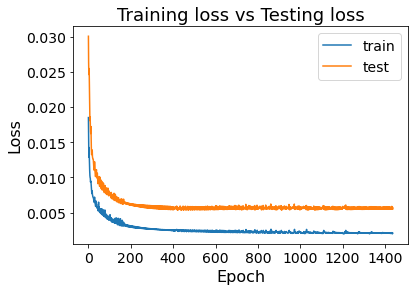

In [29]:
lr = 0.0001
EPOCHS = 3000

# initial_learning_rate * decay_rate ^ (step / decay_steps)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-4, 
                                                          decay_steps=10000,
                                                          decay_rate=0.99)

model_rnn.compile(
    optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS), 
#               optimizer=Adam(learning_rate=lr_schedule), 
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])


es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=1000)
mc = ModelCheckpoint('saved_model/rnn_shift_anyday_12h_cp0.h5', monitor='val_mae', mode='min', verbose=2, save_best_only=True)


history = model_rnn.fit(train_X, train_y,
                    batch_size=512,
                    epochs=EPOCHS,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=False,
                       callbacks=[es, mc])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Performance

In [30]:
from tensorflow.keras.models import load_model
saved_model = load_model('saved_model/rnn_shift_anyday_12h_cp0.h5')

In [31]:
yhat = saved_model.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

error = inv_yhat - inv_y
print(error.shape)

inv_y.shape, inv_yhat.shape (8744, 12) (8744, 12)
(8744, 12)


In [32]:
### check out results here
print('MAE = {}'.format(float("{:.3f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
print('RMSE = {}'.format(float("{:.3f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

MAE = 29.197
RMSE = 46.839
